IntervalTree library found.
--- Starting Source Classifier Model Pipeline (Output to: /kaggle/working/source_classifier_model/) ---

--- Verifying Essential File Paths ---
Path OK: DATA_PATH_FOR_IPS = /kaggle/input/network-intrusion-detection/BCCC-CIC-IDS2017/BCCC-CIC-IDS-2017/
Path OK: GEOLITE_ASN_BLOCKS_IPV4_CSV_PATH = /kaggle/input/iprangecsv/GeoLite2-ASN-Blocks-IPv4.csv
Essential paths verified.


--- Building Source Classifier ---
Source Classifier: Reading 'src_ip' from 18 files...
Source Classifier: Extracted 11965 unique source IPs from 2438052 total occurrences.

Source Classifier: Loading external databases for IP enrichment...
Loading and optimizing ASN Blocks & Orgs from /kaggle/input/iprangecsv/GeoLite2-ASN-Blocks-IPv4.csv...
  Processed 200000 ASN blocks...
  Processed 400000 ASN blocks...
Loaded 420217 IPv4 ASN blocks/orgs into IntervalTree.
Loading AWS IP ranges...
  Loaded from local file: /kaggle/input/iprangee/amazon.json
  Processed 6706 IPv4 AWS networks (loaded fr

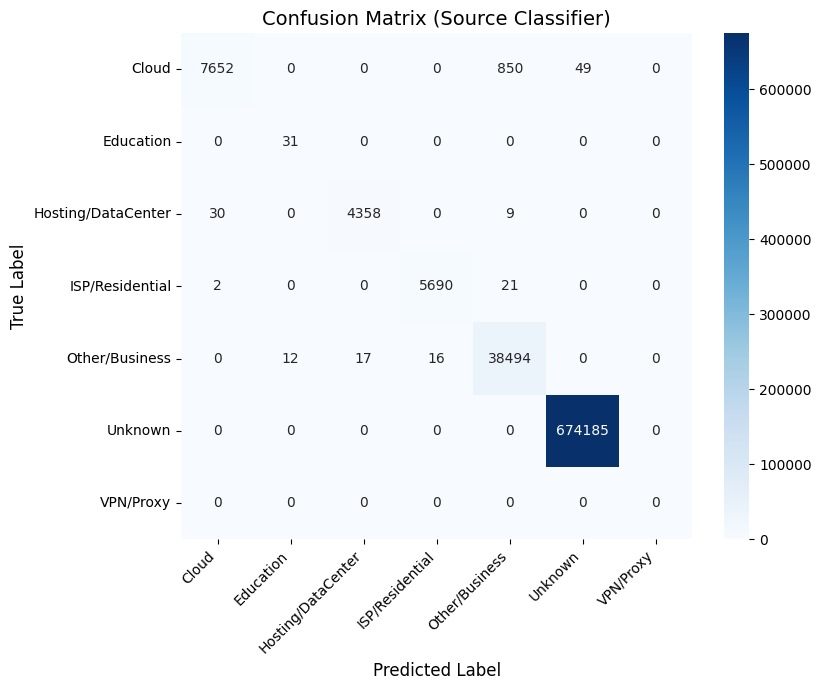


Saving Source Classifier pipeline and label encoder...
Source Classifier artifacts saved to /kaggle/working/source_classifier_model/

--- Source Classifier Model Pipeline Finished in 9m 48.46s ---


In [22]:
import pandas as pd
import numpy as np
import glob
import os
import time
import joblib
import warnings
import sys
import ipaddress # For handling IP addresses and networks
import json
import requests # For downloading cloud ranges (optional)
from functools import lru_cache # For caching lookups
import gc # For garbage collection

# --- Ensure intervaltree is installed (crucial for ASN lookup performance) ---
try:
    from intervaltree import Interval, IntervalTree
    intervaltree_available = True
    print("IntervalTree library found.")
except ImportError:
    intervaltree_available = False
    print("***************************************************************************")
    print("WARNING: 'intervaltree' library not found. ASN lookup will be VERY SLOW.")
    print("         Consider installing it in your environment:")
    print("         !pip install intervaltree")
    print("***************************************************************************")

# --- Scikit-learn Imports ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.pipeline import Pipeline

# --- Visualization Imports ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuration ---
# *** IMPORTANT: UPDATE THESE PATHS ***

# Path to the directory containing the BCCC-CIC-IDS2017 CSV files
# (e.g., monday_benign.csv, portscan.csv, etc.)
DATA_PATH = "/kaggle/input/network-intrusion-detection/BCCC-CIC-IDS2017/BCCC-CIC-IDS-2017/"

# Directory where output models and plots will be saved
OUTPUT_PATH = "/kaggle/working/source_classifier_model/" # Specific output directory
os.makedirs(OUTPUT_PATH, exist_ok=True) # Ensure directory exists

# Paths for external enrichment data files
GEOLITE_ASN_BLOCKS_IPV4_CSV_PATH = "/kaggle/input/iprangecsv/GeoLite2-ASN-Blocks-IPv4.csv" # REQUIRED

AWS_RANGES_PATH = "/kaggle/input/iprangee/amazon.json" # Local cache/download path for AWS ranges
AZURE_RANGES_PATH = "/kaggle/input/iprangee/ServiceTags_Public_20250505.json" # Local cache/download path for Azure ranges
GCP_RANGES_PATH = "/kaggle/input/iprangee/gcp.json" # Local cache/download path for GCP ranges

# Optional: Paths to text files containing lists of known VPN or Tor IPs/CIDRs (one per line)
# Using the paths from your previous multi-model script
VPN_LIST_NORDVPN_PATH = "/kaggle/input/enrichement/NordVPN-Server-IP-List.txt"
TOR_EXIT_NODES_PATH = "/kaggle/input/enrichement/tor-exit-nodes.lst"
TOR_NODES_PATH = "/kaggle/input/enrichement/tor-nodes.lst"

# URLs for downloading cloud ranges if local files are not found/specified
AWS_RANGES_URL = "https://ip-ranges.amazonaws.com/ip-ranges.json"
AZURE_RANGES_URL = "https://download.microsoft.com/download/7/1/D/71D86715-5596-4529-9B13-DA13A5DE5B63/ServiceTags_Public.json"
GCP_RANGES_URL = None # GCP doesn't provide a single JSON like AWS/Azure easily, local file preferred.

# Other Config
RANDOM_STATE = 42
# Sample fraction for the UNIQUE IPs to be enriched (can be slow)
SAMPLE_FRACTION_SOURCE_IPS_ENRICHMENT = 1.0 # Set to 1.0 as per your latest example, adjust if needed
# Sample fraction of the TOTAL IP OCCURRENCES for training the final source model
SAMPLE_FRACTION_TRAINING_SOURCE_MODEL = 1.0

# Define Target Categories for Source Classification
TARGET_SOURCE_CATEGORIES = ['ISP/Residential', 'Cloud', 'Hosting/DataCenter', 'Education', 'VPN/Proxy', 'Other/Business', 'Unknown']

# --- Global Variables for Cached Lookups ---
ASN_LOOKUP_STRUCTURE_GLOBAL = None

# --- Helper Functions ---
def plot_confusion_matrix_source(cm_df, title='Confusion Matrix (Source Classifier)', save_path=None):
    """Plots a confusion matrix, adjusting size dynamically."""
    plt.figure(figsize=(min(12, len(cm_df.columns)*1.2), min(10, len(cm_df.index)*1)))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=True, annot_kws={"size": 10})
    plt.title(title, fontsize=14); plt.ylabel('True Label', fontsize=12); plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10); plt.yticks(rotation=0, fontsize=10); plt.tight_layout()
    if save_path:
        full_save_path = os.path.join(OUTPUT_PATH, save_path)
        plt.savefig(full_save_path, bbox_inches='tight')
        print(f"Plot saved: {full_save_path}")
    plt.show(); plt.close()

# --- External Data Preparation Functions ---
def parse_ip_network(ip_str):
    """Safely parses an IP address or CIDR block string into an ipaddress object."""
    try: return ipaddress.ip_network(ip_str, strict=False)
    except ValueError: return None

def load_asn_data_optimized(asn_blocks_path):
    """
    Loads ASN blocks and organization names from the GeoLite2 ASN Blocks CSV.
    Uses IntervalTree for fast lookups if available, otherwise falls back to
    a (very slow) DataFrame iteration method.
    """
    global intervaltree_available
    print(f"Loading and optimizing ASN Blocks & Orgs from {asn_blocks_path}...")
    if not asn_blocks_path or not os.path.exists(asn_blocks_path):
        print("Error: ASN Blocks file path invalid or file not found.")
        return None

    if intervaltree_available:
        try:
            asn_tree = IntervalTree(); count = 0; skipped_lines = 0
            with open(asn_blocks_path, 'r', encoding='utf-8') as f:
                next(f)
                for line_num, line in enumerate(f, 2):
                    try:
                        parts = line.strip().split(',', 2)
                        if len(parts) != 3: skipped_lines += 1; continue
                        network_cidr, asn_num_str, asn_org_str = parts[0], parts[1], parts[2].strip('"')
                        if not asn_num_str or not network_cidr: skipped_lines += 1; continue
                        network = parse_ip_network(network_cidr)
                        if network and network.version == 4:
                            start_ip_int = int(network.network_address); end_ip_int = int(network.broadcast_address) + 1
                            asn_num = int(asn_num_str); asn_org = asn_org_str if asn_org_str else 'Unknown Org'
                            asn_tree[start_ip_int:end_ip_int] = (asn_num, asn_org); count += 1
                            if count % 200000 == 0: print(f"  Processed {count} ASN blocks...")
                    except (ValueError, IndexError): skipped_lines += 1; continue
            print(f"Loaded {count} IPv4 ASN blocks/orgs into IntervalTree.");
            if skipped_lines > 0: print(f"  Skipped {skipped_lines} malformed or non-IPv4 lines.")
            return asn_tree
        except Exception as e:
            print(f"Error loading ASN Blocks with IntervalTree: {e}\nFalling back to DataFrame method.");
            intervaltree_available = False

    if not intervaltree_available:
        print("Warning: Using SLOW ASN lookup (DataFrame iteration). This may take a very long time.")
        try:
            asn_blocks_df = pd.read_csv(
                asn_blocks_path,
                usecols=['network', 'autonomous_system_number', 'autonomous_system_organization'],
                dtype={'network': str, 'autonomous_system_number': 'Int64', 'autonomous_system_organization': str},
                na_filter=False # Handle empty strings as is
            )
            print("  Preprocessing networks for DataFrame fallback (this might take time)...")
            asn_blocks_df['network_obj'] = asn_blocks_df['network'].apply(parse_ip_network)
            asn_blocks_df = asn_blocks_df.dropna(subset=['network_obj', 'autonomous_system_number'])
            asn_blocks_df = asn_blocks_df[asn_blocks_df['network_obj'].apply(lambda x: x.version == 4)]
            # Fill empty org names after stripping quotes
            asn_blocks_df.loc[asn_blocks_df['autonomous_system_organization'] == '', 'autonomous_system_organization'] = 'Unknown Org'
            if 'network_obj' not in asn_blocks_df.columns or asn_blocks_df['network_obj'].isnull().all():
                 print("CRITICAL ERROR during DataFrame fallback: 'network_obj' column creation failed.")
                 return None
            print(f"Loaded {len(asn_blocks_df)} IPv4 ASN blocks/orgs into DataFrame for fallback.")
            return asn_blocks_df
        except Exception as e_fallback:
            print(f"Error loading ASN Blocks even for fallback method: {e_fallback}")
            return None
    return None # Should not be reached if logic is correct

def load_cloud_ranges(provider, file_path=None, url=None):
    """Loads cloud provider IP ranges from local file or downloads from URL."""
    print(f"Loading {provider} IP ranges..."); ranges_json = None; loaded_from = "unknown"
    if file_path and os.path.exists(file_path):
        try:
            with open(file_path, 'r') as f: ranges_json = json.load(f)
            print(f"  Loaded from local file: {file_path}"); loaded_from = "file"
        except Exception as e: print(f"  Error reading local file {file_path}: {e}")

    if not ranges_json and url:
        try:
            print(f"  Attempting download from {url}..."); response = requests.get(url, timeout=30); response.raise_for_status(); ranges_json = response.json(); print("  Downloaded successfully.")
            loaded_from = "download"
            if file_path:
                 try:
                      dir_name = os.path.dirname(file_path)
                      if dir_name and not os.path.exists(dir_name): os.makedirs(dir_name, exist_ok=True)
                      with open(file_path, 'w') as f: json.dump(ranges_json, f)
                      print(f"  Saved downloaded ranges to {file_path}")
                 except Exception as e_save: print(f"  Could not save downloaded ranges to {file_path}: {e_save}")
        except Exception as e_download: print(f"  Error downloading/processing {provider} ranges from {url}: {e_download}")

    if not ranges_json: print(f"  Failed to load {provider} ranges."); return frozenset()

    networks = set()
    try:
        if provider == 'AWS':
            for prefix in ranges_json.get('prefixes', []):
                 if prefix.get('ip_prefix'): net = parse_ip_network(prefix['ip_prefix']); networks.add(net) if net and net.version == 4 else None
        elif provider == 'Azure':
            for value in ranges_json.get('values', []):
                name = value.get('name', '')
                # Consider all prefixes, not just specific AzureCloud services for broader coverage
                for prefix in value.get('properties', {}).get('addressPrefixes', []):
                    net = parse_ip_network(prefix); networks.add(net) if net and net.version == 4 else None
        elif provider == 'GCP':
             for entry in ranges_json.get('prefixes', []):
                 if 'ipv4Prefix' in entry: net = parse_ip_network(entry['ipv4Prefix']); networks.add(net) if net and net.version == 4 else None
        networks.discard(None)
        print(f"  Processed {len(networks)} IPv4 {provider} networks (loaded from {loaded_from}).")
        return frozenset(networks) # Return frozenset for cacheability
    except Exception as e_parse: print(f"  Error parsing {provider} JSON: {e_parse}"); return frozenset()

def load_ip_list_from_multiple_files(file_paths_list):
    """Loads a list of IPs/CIDRs from multiple text files."""
    combined_ips_or_nets = set()
    for file_path in file_paths_list:
        if not file_path or not os.path.exists(file_path):
            print(f"IP list file not found or not specified: {file_path}")
            continue
        print(f"Loading IP list from {file_path}..."); current_file_nets = 0
        try:
            with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                for line in f:
                    line = line.strip()
                    if line and not line.startswith('#'):
                        net = parse_ip_network(line)
                        if net: combined_ips_or_nets.add(net); current_file_nets += 1
            print(f"  Loaded {current_file_nets} networks/IPs from this file.")
        except Exception as e: print(f"  Error loading IP list {file_path}: {e}")
    combined_ips_or_nets.discard(None)
    print(f"Total unique networks/IPs from all lists: {len(combined_ips_or_nets)}")
    return frozenset(combined_ips_or_nets) # Return frozenset for cacheability

# --- Lookup Functions (Cached) ---
@lru_cache(maxsize=2**18)
def get_asn_info_for_ip_cached(ip_str):
    """Looks up ASN/Org for an IP using globally loaded structures."""
    global ASN_LOOKUP_STRUCTURE_GLOBAL; asn_lookup_struct = ASN_LOOKUP_STRUCTURE_GLOBAL
    asn_num = None; asn_org = 'Unknown ASN'
    try: ip_obj = ipaddress.ip_address(ip_str)
    except ValueError: return None, 'Invalid IP String'
    if ip_obj.version != 4: return None, 'Non-IPv4 Address'
    if asn_lookup_struct is None: return None, 'ASN DB Not Loaded'

    try:
        if isinstance(asn_lookup_struct, pd.DataFrame):
             if 'network_obj' not in asn_lookup_struct.columns: return None, 'Lookup Error (network_obj missing)'
             for idx, row in asn_lookup_struct.iterrows():
                if ip_obj in row['network_obj']:
                    asn_num = row.get('autonomous_system_number')
                    asn_org = row.get('autonomous_system_organization', 'Unknown Org')
                    break
        elif intervaltree_available and isinstance(asn_lookup_struct, IntervalTree):
            ip_int = int(ip_obj); intervals = asn_lookup_struct[ip_int]
            if intervals:
                interval_data = min(intervals, key=lambda i: i.end - i.begin).data
                if isinstance(interval_data, tuple) and len(interval_data) == 2:
                    asn_num, asn_org = interval_data
                else: asn_org = 'ASN Lookup Format Error'
        else: return None, 'ASN DB Type Invalid'

        if asn_num is not None and not pd.isna(asn_num): asn_num = int(asn_num)
        else: asn_num = None
        if pd.isna(asn_org) or not asn_org: asn_org = 'Unknown Org'
    except Exception as e:
        # Consider logging to a file for frequent errors instead of console
        # print(f"Debug: ASN Lookup Exception for {ip_str}: {str(e)[:50]}")
        asn_org = f'ASN Lookup Exception' # Simplified error message
    return asn_num, asn_org

@lru_cache(maxsize=2**18)
def check_ip_membership(ip_str, aws_nets_f, azure_nets_f, gcp_nets_f, vpn_nets_f, tor_nets_f):
     """Checks IP membership against multiple FROZEN network sets."""
     try: ip_obj = ipaddress.ip_address(ip_str)
     except ValueError: return False, False, False, False, False
     if ip_obj.version != 4: return False, False, False, False, False
     is_aws = any(ip_obj in net for net in aws_nets_f)
     is_azure = any(ip_obj in net for net in azure_nets_f) if not is_aws else False
     is_gcp = any(ip_obj in net for net in gcp_nets_f) if not (is_aws or is_azure) else False
     is_vpn = any(ip_obj in net for net in vpn_nets_f)
     is_tor = any(ip_obj in net for net in tor_nets_f) # Tor can overlap with VPN, check independently
     return is_aws, is_azure, is_gcp, is_vpn, is_tor

# --- Categorize Source ---
def categorize_source(asn_org_str, is_cloud, is_proxy):
    """Categorizes source based on ASN Org string, cloud flag, and proxy flag."""
    if is_proxy: return 'VPN/Proxy'
    if is_cloud: return 'Cloud'
    if pd.isna(asn_org_str) or not isinstance(asn_org_str, str) or "Unknown" in asn_org_str or "Error" in asn_org_str or not asn_org_str:
        return 'Unknown'
    org_lower = asn_org_str.lower()
    hosting_kws = ['hosting', 'host', 'ovh', 'linode', 'digitalocean', 'hetzner', 'server', 'data center', 'datacenter', 'online sas', 'leaseweb', 'contabo', 'dedicated', 'colocation', 'cdn', 'vultr', 'equinix', 'intergenia', 'ionos', 'godaddy', 'google cloud', 'amazon technologies', 'microsoft corporation'] # Added common cloud provider names
    edu_kws = ['university', 'college', 'school', 'institute of technology', 'research', 'education', 'academic', 'national laboratory', 'bibliothek', 'universitat', 'ecole', 'universidad', 'renater'] # Added RENATER
    isp_kws = ['isp', 'internet', 'telecom', 'communication', 'cable', 'broadband', 'mobile', 'residential', 'verizon', 'comcast', 'at&t', 'centurylink', 'spectrum', 'telefonica', 'deutsche telekom', 'orange', 'telia', 'vodafone', 'telstra', 'bt ', 'sky ', 'telus', 'bell canada', 'rogers', 'reliance jio', 'bharti airtel', 'telemar', 'optus', 'swisscom', 'liberty global', 'tim ', 'claro', 'charter ', 'cox ', 'sprint', 't-mobile'] # Added common mobile carriers
    business_kws = ['inc', 'ltd', 'llc', 'corp', 'corporation', 'group', 'gmbh', 's.a', 'l.p.', 'limited', 'plc', 'associates', 'bank', 'financial', 'versicherung', 'ag', 'b.v.', 's.p.a.', 'holdings', 'llp'] # Added LLP

    if any(kw in org_lower for kw in hosting_kws): return 'Hosting/DataCenter'
    if any(kw in org_lower for kw in edu_kws): return 'Education'
    if any(kw in org_lower for kw in isp_kws): return 'ISP/Residential'
    if any(kw in org_lower for kw in business_kws): return 'Other/Business'
    return 'Other/Business'

# --- Enrich IP Data (Optimized) ---
def enrich_ip_data(unique_ips_df_input, aws_nets_f, azure_nets_f, gcp_nets_f, vpn_nets_f, tor_nets_f):
    """Adds ASN, Cloud, VPN/Tor info using optimized lookups and global ASN structure."""
    global ASN_LOOKUP_STRUCTURE_GLOBAL
    asn_lookup_possible = (ASN_LOOKUP_STRUCTURE_GLOBAL is not None)
    lookup_method_str = 'No ASN Lookup'
    if asn_lookup_possible:
        if intervaltree_available and isinstance(ASN_LOOKUP_STRUCTURE_GLOBAL, IntervalTree): lookup_method_str = 'IntervalTree'
        elif isinstance(ASN_LOOKUP_STRUCTURE_GLOBAL, pd.DataFrame): lookup_method_str = 'DataFrame Fallback'

    print(f"Enriching {len(unique_ips_df_input)} unique IPs (ASN lookup: {lookup_method_str})...")
    enriched_results = {}; start_time = time.time(); processed_count = 0; total_ips = len(unique_ips_df_input)

    for ip in unique_ips_df_input['Source IP']:
        processed_count += 1
        if processed_count % 20000 == 0 or processed_count == total_ips:
             elapsed = time.time() - start_time; rate = processed_count / elapsed if elapsed > 0 else 0
             print(f"  Processed {processed_count}/{total_ips} IPs ({rate:.1f} IPs/sec)...")

        asn_num_val, asn_org_val = (-1, 'ASN DB Error') if not asn_lookup_possible else get_asn_info_for_ip_cached(ip)
        is_aws_val, is_azure_val, is_gcp_val, is_vpn_val, is_tor_val = check_ip_membership(ip, aws_nets_f, azure_nets_f, gcp_nets_f, vpn_nets_f, tor_nets_f)
        is_cloud_val = is_aws_val or is_azure_val or is_gcp_val
        is_proxy_val = is_vpn_val or is_tor_val
        final_category_val = categorize_source(asn_org_val, is_cloud_val, is_proxy_val)
        enriched_results[ip] = {
            'ASN': asn_num_val if asn_num_val is not None else -1,
            'ASN_Org': asn_org_val,
            'Is_Cloud': is_cloud_val,
            'Is_Proxy': is_proxy_val,
            'Source_Category': final_category_val
        }
    print(f"Finished enriching {processed_count} IPs in {time.time() - start_time:.2f} seconds.")
    if not enriched_results: return pd.DataFrame()
    enriched_df = pd.DataFrame.from_dict(enriched_results, orient='index')
    enriched_df.index.name = 'Source IP_orig'; enriched_df.reset_index(inplace=True)
    enriched_df.rename(columns={'Source IP_orig': 'Source IP'}, inplace=True)
    return enriched_df

# --- Prepare Data for Model ---
def prepare_source_model_data(main_df_with_all_ips, enriched_ip_df_unique):
    """
    Merges enrichment data with all IP occurrences and prepares X, y for the source classifier.
    Crucially, it uses 'Source IP' as the key and does NOT pass 'Source IP' to the model as a feature,
    preventing direct data leakage.
    """
    print("Preparing data for Source Classifier model...")
    if 'Source IP' not in main_df_with_all_ips.columns: raise ValueError("'Source IP' column missing from main_df_with_all_ips")
    if 'Source IP' not in enriched_ip_df_unique.columns: raise ValueError("'Source IP' column missing from enriched_ip_df_unique")

    main_df_with_all_ips['Source IP'] = main_df_with_all_ips['Source IP'].astype(str)
    enriched_ip_df_unique['Source IP'] = enriched_ip_df_unique['Source IP'].astype(str)

    # --- Data Leakage Prevention: Merge based on 'Source IP' to get features, but 'Source IP' itself is NOT a feature for the model ---
    print(f"Merging enrichment data (Unique IPs enriched: {len(enriched_ip_df_unique)}) with main data (Total IP occurrences: {len(main_df_with_all_ips)})...")
    # We select ONLY the 'Source IP' from main_df to ensure we only merge on this key.
    # The enriched_ip_df_unique contains the features derived from 'Source IP'.
    merged_df = pd.merge(main_df_with_all_ips[['Source IP']],
                         enriched_ip_df_unique, # This contains 'ASN', 'ASN_Org', 'Is_Cloud', 'Is_Proxy', 'Source_Category'
                         on='Source IP',
                         how='left')

    fill_values = {'ASN': -1, 'ASN_Org': 'Unknown Not Enriched', 'Is_Cloud': False, 'Is_Proxy': False, 'Source_Category': 'Unknown'}
    merged_df.fillna(value=fill_values, inplace=True)

    print("Defining features and target. 'Source IP' will NOT be a feature.")
    # Features for the model are derived characteristics of the IP, NOT the IP itself.
    categorical_features = ['ASN_Org'] # Example: Organization name (string)
    numerical_features = ['ASN', 'Is_Cloud', 'Is_Proxy'] # ASN (number), Cloud/Proxy flags (boolean/int)
    target_col = 'Source_Category'

    # Ensure all selected features are present in the merged_df
    missing_features = [f for f in categorical_features + numerical_features if f not in merged_df.columns]
    if missing_features:
        raise ValueError(f"One or more features are missing from the merged DataFrame after enrichment: {missing_features}")

    # X contains ONLY the derived features, not 'Source IP'
    X = merged_df[categorical_features + numerical_features].copy()
    y_strings = merged_df[target_col].apply(lambda x: x if x in TARGET_SOURCE_CATEGORIES else 'Unknown')

    if X.empty: raise ValueError("Feature set X is empty after merge/selection.")

    label_encoder_source = LabelEncoder()
    label_encoder_source.fit(TARGET_SOURCE_CATEGORIES)
    y = label_encoder_source.transform(y_strings)

    print(f"Source Classifier Target mapping: {dict(zip(label_encoder_source.classes_, label_encoder_source.transform(label_encoder_source.classes_)))}")
    print(f"Final X shape (features for model): {X.shape}, y shape (target): {y.shape}")
    print(f"Class distribution in y (encoded):\n{pd.Series(y).value_counts(normalize=True).sort_index()}")
    print(f"Class distribution in y (strings):\n{y_strings.value_counts(normalize=True).sort_index()}")
    return X, y, label_encoder_source

# --- Train and Evaluate Source Classifier ---
def train_evaluate_source_model(X, y, label_encoder):
    """Trains and evaluates the source classifier model using a scikit-learn Pipeline."""
    print("\nSplitting data for Source Classifier...")
    unique_classes_y, counts_y = np.unique(y, return_counts=True)
    min_samples_for_stratify = counts_y.min() if len(counts_y) > 0 else 0
    can_stratify = min_samples_for_stratify >= 2 and len(unique_classes_y) > 1

    if can_stratify:
        print(f"Stratifying train/test split (min_samples={min_samples_for_stratify}).")
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y)
    else:
        print(f"Warning - No stratification (min_samples={min_samples_for_stratify}, unique_classes={len(unique_classes_y)}).")
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

    print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

    categorical_features_in_X = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_features_in_X = X_train.select_dtypes(include=np.number).columns.tolist()

    if categorical_features_in_X:
        X_train.loc[:, categorical_features_in_X] = X_train[categorical_features_in_X].astype(str)
        X_test.loc[:, categorical_features_in_X] = X_test[categorical_features_in_X].astype(str)

    transformers_list = []
    if numerical_features_in_X: transformers_list.append(('num', StandardScaler(), numerical_features_in_X))
    if categorical_features_in_X:
        transformers_list.append(('cat_ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False, min_frequency=0.001), categorical_features_in_X))
    if not transformers_list: raise ValueError("Source Classifier: No features to transform.")

    preprocessor = ColumnTransformer(transformers=transformers_list, remainder='drop')
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(
            n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1,
            class_weight='balanced', max_depth=25, min_samples_leaf=5,
            min_samples_split=10, verbose=0
        ))
    ])

    print("\nTraining Source Classifier Pipeline..."); start_time_train = time.time()
    model_pipeline.fit(X_train, y_train)
    print(f"Training complete in {time.time() - start_time_train:.2f}s.")

    print("\nEvaluating Source Classifier on Test Set..."); y_pred = model_pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred); f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
    print(f"\nTest Accuracy: {accuracy:.4f}"); print(f"Test F1 Macro: {f1_macro:.4f}")

    print("\nTest Classification Report (Source Classifier):")
    report_class_names = label_encoder.classes_
    present_labels_idx = np.unique(np.concatenate((y_test, y_pred)))
    valid_report_labels_idx = [l for l in present_labels_idx if 0 <= l < len(report_class_names)]
    if not valid_report_labels_idx:
        target_names_for_report = [str(l) for l in present_labels_idx]; labels_for_report = present_labels_idx
    else:
        target_names_for_report = label_encoder.inverse_transform(valid_report_labels_idx); labels_for_report = valid_report_labels_idx
    report = classification_report(y_test, y_pred, labels=labels_for_report, target_names=target_names_for_report, zero_division=0, digits=3)
    print(report)

    print("\nTest Confusion Matrix (Source Classifier):")
    cm_labels_indices = label_encoder.transform(report_class_names)
    cm = confusion_matrix(y_test, y_pred, labels=cm_labels_indices)
    cm_df = pd.DataFrame(cm, index=report_class_names, columns=report_class_names)
    plot_confusion_matrix_source(cm_df, save_path="source_classifier_confusion_matrix.png")

    print("\nSaving Source Classifier pipeline and label encoder...")
    pipeline_filename = os.path.join(OUTPUT_PATH, "source_classifier_pipeline.joblib")
    encoder_filename = os.path.join(OUTPUT_PATH, "source_classifier_label_encoder.joblib")
    try:
        joblib.dump(model_pipeline, pipeline_filename)
        joblib.dump(label_encoder, encoder_filename)
        print(f"Source Classifier artifacts saved to {OUTPUT_PATH}")
    except Exception as e_save_model: print(f"Error saving model Source Classifier: {e_save_model}")
    return model_pipeline

# --- Main Execution Block ---
if __name__ == "__main__":
    main_start_time = time.time()
    print(f"--- Starting Source Classifier Model Pipeline (Output to: {OUTPUT_PATH}) ---")
    warnings.filterwarnings("ignore", category=UserWarning)
    warnings.filterwarnings("ignore", category=FutureWarning)
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    warnings.filterwarnings("ignore", category=pd.errors.DtypeWarning) # For mixed types during initial CSV read

    try:
        print("\n--- Verifying Essential File Paths ---")
        essential_paths_config = {"DATA_PATH_FOR_IPS": (DATA_PATH, 'dir'), "GEOLITE_ASN_BLOCKS_IPV4_CSV_PATH": (GEOLITE_ASN_BLOCKS_IPV4_CSV_PATH, 'file')}
        optional_file_paths = {
            "AWS_RANGES_PATH": AWS_RANGES_PATH, "AZURE_RANGES_PATH": AZURE_RANGES_PATH,
            "GCP_RANGES_PATH": GCP_RANGES_PATH, "VPN_LIST_NORDVPN_PATH": VPN_LIST_NORDVPN_PATH,
            "TOR_EXIT_NODES_PATH": TOR_EXIT_NODES_PATH, "TOR_NODES_PATH": TOR_NODES_PATH
        }
        all_paths_valid = True
        for name, (path_to_check, path_type) in essential_paths_config.items():
            if not path_to_check: print(f"CRITICAL ERROR: Path for {name} not set."); all_paths_valid = False; break
            if path_type == 'dir' and not os.path.isdir(path_to_check): print(f"CRITICAL ERROR: Dir for {name} not found: {path_to_check}"); all_paths_valid = False; break
            elif path_type == 'file' and not os.path.isfile(path_to_check): print(f"CRITICAL ERROR: File for {name} not found: {path_to_check}"); all_paths_valid = False; break
            print(f"Path OK: {name} = {path_to_check}")
        if not all_paths_valid: print("Critical paths invalid. Exiting."); sys.exit(1)
        else: print("Essential paths verified.")
        for name, path_to_check in optional_file_paths.items():
            if path_to_check and not os.path.exists(path_to_check): print(f"Warning: Optional file for {name} not found at {path_to_check}.")

        print("\n\n--- Building Source Classifier ---")
        src_ip_col_name_cicids = 'src_ip'; all_source_ips_list_for_enrich = []
        source_model_csv_files = glob.glob(os.path.join(DATA_PATH, "*.csv"))
        if not source_model_csv_files: print(f"CRITICAL: No CSVs in {DATA_PATH}."); sys.exit(1)

        print(f"Source Classifier: Reading '{src_ip_col_name_cicids}' from {len(source_model_csv_files)} files...")
        for file_path in source_model_csv_files:
            try:
                temp_df_cols = pd.read_csv(file_path, nrows=0).columns.str.strip()
                if src_ip_col_name_cicids in temp_df_cols:
                    df_single_col = pd.read_csv(file_path, usecols=[src_ip_col_name_cicids], low_memory=False, comment='#', dtype={src_ip_col_name_cicids: str})
                    df_single_col.columns = df_single_col.columns.str.strip()
                    all_source_ips_list_for_enrich.append(df_single_col[src_ip_col_name_cicids])
            except pd.errors.EmptyDataError: pass
            except Exception as e: print(f"  Source Classifier: Error reading {os.path.basename(file_path)}: {e}")

        if not all_source_ips_list_for_enrich: print(f"CRITICAL: Could not read '{src_ip_col_name_cicids}'."); sys.exit(1)
        all_source_ips_series = pd.concat(all_source_ips_list_for_enrich, ignore_index=True)
        unique_source_ips = all_source_ips_series.dropna().unique()
        unique_ips_df_for_enrich = pd.DataFrame({'Source IP': unique_source_ips})
        print(f"Source Classifier: Extracted {len(unique_ips_df_for_enrich)} unique source IPs from {len(all_source_ips_series)} total occurrences.")
        del all_source_ips_list_for_enrich; gc.collect()

        if SAMPLE_FRACTION_SOURCE_IPS_ENRICHMENT < 1.0 and len(unique_ips_df_for_enrich) > 0:
            n_samples = max(1, int(len(unique_ips_df_for_enrich) * SAMPLE_FRACTION_SOURCE_IPS_ENRICHMENT))
            print(f"Source Classifier: Sampling {n_samples} unique IPs for enrichment...");
            unique_ips_df_for_enrich = unique_ips_df_for_enrich.sample(n=n_samples, random_state=RANDOM_STATE).reset_index(drop=True)

        print("\nSource Classifier: Loading external databases for IP enrichment...")
        ASN_LOOKUP_STRUCTURE_GLOBAL = load_asn_data_optimized(GEOLITE_ASN_BLOCKS_IPV4_CSV_PATH)
        if ASN_LOOKUP_STRUCTURE_GLOBAL is None: print("Warning: ASN Lookup structure None. Enrichment will be limited.")

        aws_nets_frozen = load_cloud_ranges('AWS', AWS_RANGES_PATH, AWS_RANGES_URL)
        azure_nets_frozen = load_cloud_ranges('Azure', AZURE_RANGES_PATH, AZURE_RANGES_URL)
        gcp_nets_frozen = load_cloud_ranges('GCP', GCP_RANGES_PATH, GCP_RANGES_URL)
        vpn_files_to_load = [p for p in [VPN_LIST_NORDVPN_PATH] if p and os.path.exists(p)] # Make sure path exists
        vpn_nets_frozen = load_ip_list_from_multiple_files(vpn_files_to_load)
        tor_files_to_load = [p for p in [TOR_EXIT_NODES_PATH, TOR_NODES_PATH] if p and os.path.exists(p)] # Make sure paths exist
        tor_nets_frozen = load_ip_list_from_multiple_files(tor_files_to_load)

        if not unique_ips_df_for_enrich.empty:
            enriched_ips_df_source_model = enrich_ip_data(
                unique_ips_df_for_enrich, aws_nets_frozen, azure_nets_frozen,
                gcp_nets_frozen, vpn_nets_frozen, tor_nets_frozen
            )
            if enriched_ips_df_source_model.empty and len(unique_ips_df_for_enrich) > 0:
                print("Warning: IP Enrichment for Source Classifier Model resulted in empty DataFrame."); sys.exit(1)

            # For training, use all IP occurrences (or a sample of them) and merge with enriched data
            main_df_for_source_model_training = pd.DataFrame({'Source IP': all_source_ips_series.dropna().astype(str)})
            del all_source_ips_series; gc.collect()

            if SAMPLE_FRACTION_TRAINING_SOURCE_MODEL < 1.0 and len(main_df_for_source_model_training) > 0:
                print(f"Source Classifier: Sampling {SAMPLE_FRACTION_TRAINING_SOURCE_MODEL*100:.1f}% of IP instances for training...")
                main_df_for_source_model_training = main_df_for_source_model_training.sample(
                    frac=SAMPLE_FRACTION_TRAINING_SOURCE_MODEL, random_state=RANDOM_STATE
                ).reset_index(drop=True)

            if not enriched_ips_df_source_model.empty:
                X_source_cat, y_source_cat, source_label_encoder = prepare_source_model_data(
                    main_df_for_source_model_training, enriched_ips_df_source_model
                )
                del main_df_for_source_model_training, enriched_ips_df_source_model; gc.collect()

                if not X_source_cat.empty and len(np.unique(y_source_cat)) > 1:
                     train_evaluate_source_model(X_source_cat, y_source_cat, source_label_encoder)
                elif X_source_cat.empty: print("Source Classifier: Skipping training - Feature set X_source_cat empty.")
                else:
                    print(f"Source Classifier: Skipping training - Only {len(np.unique(y_source_cat))} class(es) in y_source_cat.")
                    print(f"Value Counts of target categories:\n{pd.Series(source_label_encoder.inverse_transform(y_source_cat)).value_counts()}")
            else: print("Source Classifier: Skipping training - Enriched IP DataFrame empty.")
        else: print("Source Classifier: Skipping enrichment - no unique IPs.")

    except FileNotFoundError as e: print(f"\nError - File Not Found: {e}. Check paths."); import traceback; traceback.print_exc()
    except ValueError as e: print(f"\nValueError: {e}"); import traceback; traceback.print_exc()
    except ImportError as e: print(f"\nImportError: {e}. Install missing libraries."); import traceback; traceback.print_exc()
    except Exception as e: print(f"\nAn unexpected error occurred: {e}"); import traceback; traceback.print_exc()
    finally:
        total_time = time.time() - main_start_time
        print(f"\n--- Source Classifier Model Pipeline Finished in {total_time//60:.0f}m {total_time%60:.2f}s ---")